# Library I used

In [ ]:
import pandas as pd 
from pandas import read_csv
import numpy as np 
import random
import scipy
from scipy.sparse.coo import coo_matrix
from scipy import sparse
import networkx as nx 
import math

# Functions from HW3

In [ ]:
# read the data file
def read_data(filepath):
    data = pd.read_csv(filepath,
                         sep=" ",
                         header=None)
    data.columns = ["col", "row", "data"]
    vals = data["data"]
    cols = data["col"]
    rows = data["row"]

    if min(cols) == 1 and min(rows) == 1:
        cols = [i - 1 for i in cols]
        rows = [i - 1 for i in rows]

    return coo_matrix((vals, (cols, rows))).tocsr()

In [ ]:
# we need to make adjacence matrix to get laplacian matrix
def make_adj_mtx(A):   
    n = A.shape[0]
    adj = np.zeros((n,n)) # initialize to zero
    for i in range (n):
      for j in range (n):
        if A[i, j] != 0: # if data exists
          adj[i, j] = 1
    adj = sparse.csr_matrix(adj)   # Here's the initialization of the sparse matrix.
    
    return adj

In [ ]:
# we also need to make diagonal matrix to get laplacian matrix
def make_diag_mtx(A):
    n = A.shape[0]
    D = np.zeros((n,n)) # initialize
    for i in range (n):
      rowsum = 0
      for j in range (n):
         rowsum += abs(A[i, j])
      D[i, i] = rowsum
    D = sparse.csr_matrix(D)   
    
    return D

In [ ]:
# get laplacian matrix (L = D - A)
def make_Laplacian(diag,adj):
    L = diag - adj
    
    return L

In [ ]:
# make edge-edge connectivity matrix
def make_edge_edge_mtx(E):
    E_transpose = np.transpose(E)
    A_e = E @ E_transpose

    return E_transpose, A_e

In [ ]:
# make the weight vector (w_e)
def make_edge_weight(E):
    w_vector = []
    
    for i in range (E.shape[0]):
      w_vector.append(random.uniform(0, 1))
    
    return w_vector

In [ ]:
def make_edge_vertex_mtx(B):

    row  = []
    col  = []
    data = []
    l = 0
    
    for i in range(0, B.indices[-1] + 1):
        for k in range(B.indptr[i], B.indptr[i + 1]):
            j = B.indices[k]
            if i < j:
                data += [1., 1.]
                col  += [i, j]
                row  += [l, l]
                l += 1
    
    return coo_matrix((data, (row, col))).tocsr()

In [ ]:
def luby_p_vector(mtx, B, weight): # B is edge-edge connectivity matrix and weight is edge weight
    p_arr = np.array([])
    empty = True

    for i in range (0, len(mtx.indptr) - 1):
      visited = False
      std = 0 # initialize the standard variable
      for j in range (B.indptr[i], B.indptr[i+1]): 
        k = B.indices[j]
        if visited == False:
          std = weight[k] 
          visited = True
        if std < weight[k]:
          break # stop checking
        if j == (B.indptr[i+1] - 1): # last one
          if empty == True:
            new_column = np.array([0 for k in range (len(mtx.indptr)-1)])
            new_column[i] = 1 
            new_column[k] = 1
            p_arr = np.append(p_arr, new_column, axis = 0) 
            empty = False
          else:
            new_column = np.array([0 for k in range (len(mtx.indptr)-1)])
            new_column[i] = 1
            new_column[k] = 1
            p_arr = np.column_stack((p_arr, new_column))
    
    if empty == True: # still empty (no p_arr, so no aggregate at all)
      new_column = np.array([0 for k in range (len(mtx.indptr)-1)])
      p_arr = np.append(p_arr, new_column, axis = 0) 
    else: # not empty and already has p_arr
      p_arr = np.transpose(p_arr)

    pvec = p_arr
    pvec = sparse. csr_matrix(pvec) # to csr
    
    return pvec

In [ ]:
# create a coarse graph
def luby_coarse(mtx): 
    E = make_edge_vertex_mtx(mtx)
    E_T, B = make_edge_edge_mtx(E)
    weight = make_edge_weight(E)
    pmtx = luby_p_vector(mtx, B, weight) # pmtx is vertex - aggregate
    pmtx_T = check_missing_vertices(E_T, pmtx.T)

    return pmtx * mtx * pmtx.T 

In [ ]:
# check the missing vertices which are not labeled as aggregate
def check_missing_vertices(E, pmtx): # actually E_T and pmtx.T (skipped T for convenience)
  
  p_arr = np.array([])
  single_vertex = np.array([])
  empty = True

  for i in range (0, len(pmtx.indptr) - 1): 
    for j in range (pmtx.indptr[i], pmtx.indptr[i+1]): 
      k = pmtx.indices[j]
      p_arr = np.append(p_arr, k)      
      p_arr.sort() # sort the array to ascending order
      p_arr = list(set(p_arr)) # to remove duplicated from list 
  
  if len(p_arr) != 0:
    for a in range (0, pmtx.shape[0]): # 0-8
      found_vertex = False
      for b in range (0, len(p_arr)): 
        if a == p_arr[b]:
          found_vertex = True
          break
      if found_vertex == False:
        if empty == True:
          new_column = np.array([0 for k in range (pmtx.shape[0])]) 
          new_column[a] = 1                 
          single_vertex = np.append(single_vertex, new_column, axis = 0) 
          empty = False
        else:
          # Array to be added as column
          new_column = np.array([0 for k in range (pmtx.shape[0])]) 
          new_column[a] = 1
          single_vertex = np.column_stack((single_vertex, new_column))

  else: # if length of p_arr is zero 
    # need to create the single vertex matrix from 0 to 8
    single_vertex = np.zeros((E.shape[0], E.shape[0]), int)
    np.fill_diagonal(single_vertex, 1)
    empty = False

  if empty == False:
    single_vertex = scipy.sparse.csr_matrix(single_vertex) # to csr
    if len(p_arr) != 0:
      pmtx = scipy.sparse.hstack((pmtx, single_vertex), format = 'csr')
    else:
      pmtx = single_vertex
      
  return pmtx


In [ ]:
def main(filepath):

  mtx = read_data(filepath) 
  A_c = mtx
  iter = 0
  max_iter = 1000
 
  while iter < max_iter: 
      stopping = math.floor(A_c.shape[0]/8)
      if stopping <= 0: #satisfies stopping:check if graph is small enough 
            break
      else:
            A_c = luby_coarse(mtx) #do luby coarsing 
      iter += 1 
  return A_c

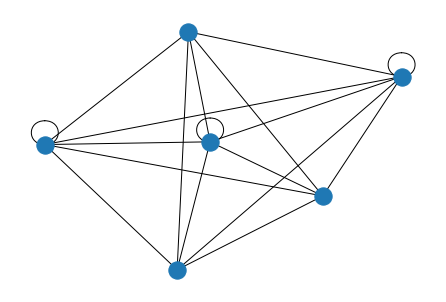

In [ ]:
# Test the functions with karate graph inputs

# with the karate graph
karate = main("karate_club_graph-1.txt")

# visualize the graph
G = nx.from_scipy_sparse_matrix(karate) 
nx.draw(G)

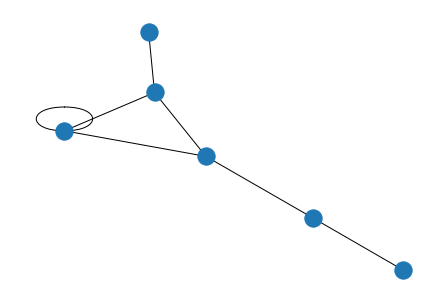

In [ ]:
# Test the functions with tutee graph inputs

# with the tutee graph
tutee = main("tutee_graph-1.txt")

# visualize the graph
G = nx.from_scipy_sparse_matrix(tutee) 
nx.draw(G)